In [1]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
import numpy as np

## Download the flower_photos dataset

In [2]:
!wget https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz

--2021-11-02 18:53:21--  https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz
Resolving storage.googleapis.com (storage.googleapis.com)... 64.233.189.128, 108.177.97.128, 108.177.125.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|64.233.189.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 228813984 (218M) [application/x-compressed-tar]
Saving to: ‘flower_photos.tgz’

flower_photos.tgz   100%[===================>] 218.21M   112MB/s    in 2.0s    

2021-11-02 18:53:24 (112 MB/s) - ‘flower_photos.tgz’ saved [228813984/228813984]



## Unzip the dataset

In [3]:
!tar -xzvf "flower_photos.tgz" -C "." > xx
print("Unzipped")

Unzipped


## Load images

In [3]:
import cv2
import os
def load_img(indir):
    samples = []
    labels = []
    for class_dir in os.listdir(indir):
        if not os.path.isdir(indir+'/'+class_dir): 
          continue
        print("Loading:",class_dir)
        the_class = class_dir
        for file in os.listdir(indir+'/'+class_dir):
            image = cv2.imread("{}/{}/{}".format(indir,class_dir,file))
            image = cv2.resize(image, (64,64))
            samples.append(image)
            labels.append(the_class)
    samples = np.array(samples)
    labels = np.array(labels)
    return samples,labels
samples, labels = load_img('flower_photos')
print('loaded',len(samples),' samples')
print('classes',set(labels))
org_samples = samples
org_labels = labels

Loading: daisy
Loading: dandelion
Loading: roses
Loading: sunflowers
Loading: tulips
loaded 3670  samples
classes {'sunflowers', 'dandelion', 'tulips', 'daisy', 'roses'}


## Show examples

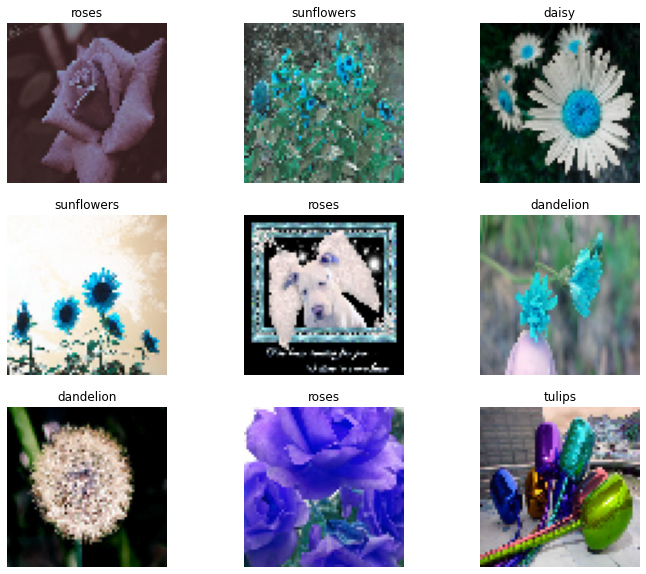

In [4]:
import matplotlib.pyplot as plt
import random
    
plt.figure(figsize=(12, 10))
for i in range(9):
    n = random.randrange(len(samples))
    plt.subplot(3, 3, i + 1)
    plt.imshow(samples[n])
    plt.title(labels[n])
    plt.axis("off")

## Create a CNN model

In [5]:
from tensorflow.keras.layers import Dense, Activation, Dropout, Flatten, Conv2D, MaxPooling2D, BatchNormalization
model = Sequential()
model.add(Conv2D(16, (3, 3), padding="same",input_shape=(64,64,3)))
model.add(BatchNormalization())
model.add(Activation("relu"))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(32, (3, 3), padding="same"))
model.add(BatchNormalization())
model.add(Activation("relu"))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(512))
model.add(Activation("relu"))
model.add(Dense(5))
model.add(Activation("softmax"))

model.summary()
optimizer = tf.keras.optimizers.RMSprop(0.0001, decay = 1e-6)
model.compile(loss='categorical_crossentropy', optimizer=optimizer,metrics=['accuracy'])


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 64, 64, 16)        448       
_________________________________________________________________
batch_normalization (BatchNo (None, 64, 64, 16)        64        
_________________________________________________________________
activation (Activation)      (None, 64, 64, 16)        0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 32, 32, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 32, 32, 32)        4640      
_________________________________________________________________
batch_normalization_1 (Batch (None, 32, 32, 32)        128       
_________________________________________________________________
activation_1 (Activation)    (None, 32, 32, 32)        0

## One-hot labels

In [6]:
# one-hot labels
from sklearn.preprocessing import LabelBinarizer
lb = LabelBinarizer()
labels = lb.fit_transform(labels)
print("Labels shape",labels.shape)
labels = labels.astype(float)

Labels shape (3670, 5)


## Train model

In [7]:
print(samples.shape)
import sklearn.model_selection
(trainSamples, testSamples, trainLabels, testLabels) = sklearn.model_selection.train_test_split(samples,labels,random_state=22)
model.compile(loss='categorical_crossentropy', optimizer="adam",metrics=['accuracy'])

(3670, 64, 64, 3)


In [8]:
H = model.fit(trainSamples, trainLabels, epochs=20, validation_data=(testSamples,testLabels))    

Epoch 1/20
86/86 [==============================] - 9s 110ms/step - loss: 2.2496 - accuracy: 0.4673 - val_loss: 1.4184 - val_accuracy: 0.4390
Epoch 2/20
86/86 [==============================] - 10s 112ms/step - loss: 1.0252 - accuracy: 0.5959 - val_loss: 1.1609 - val_accuracy: 0.5338
Epoch 3/20
86/86 [==============================] - 10s 117ms/step - loss: 0.8833 - accuracy: 0.6541 - val_loss: 1.1946 - val_accuracy: 0.5556
Epoch 4/20
86/86 [==============================] - 10s 120ms/step - loss: 0.7934 - accuracy: 0.6850 - val_loss: 1.1516 - val_accuracy: 0.5773
Epoch 5/20
86/86 [==============================] - 11s 130ms/step - loss: 0.7021 - accuracy: 0.7340 - val_loss: 0.9848 - val_accuracy: 0.6002
Epoch 6/20
86/86 [==============================] - 11s 124ms/step - loss: 0.5754 - accuracy: 0.7863 - val_loss: 1.0284 - val_accuracy: 0.6253
Epoch 7/20
86/86 [==============================] - 11s 129ms/step - loss: 0.5189 - accuracy: 0.8052 - val_loss: 1.0399 - val_accuracy: 0.6383


## Show results

In [9]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, cohen_kappa_score
testResults = model.predict(testSamples)

print(confusion_matrix(testLabels.argmax(axis=1), testResults.argmax(axis=1)))
print(classification_report(testLabels.argmax(axis=1), testResults.argmax(axis=1)))
print("Cohen's Kappa: {}".format(cohen_kappa_score(testLabels.argmax(axis=1), testResults.argmax(axis=1))))
print("Accuracy: ",accuracy_score(testLabels.argmax(axis=1), testResults.argmax(axis=1)))


[[ 90  50  18   2  11]
 [ 13 176   8   9  10]
 [ 10  16 102   1  28]
 [ 10  36   7 101  11]
 [ 10  21  52   6 120]]
              precision    recall  f1-score   support

           0       0.68      0.53      0.59       171
           1       0.59      0.81      0.68       216
           2       0.55      0.65      0.59       157
           3       0.85      0.61      0.71       165
           4       0.67      0.57      0.62       209

    accuracy                           0.64       918
   macro avg       0.67      0.64      0.64       918
weighted avg       0.66      0.64      0.64       918

Cohen's Kappa: 0.5484006022880367
Accuracy:  0.6416122004357299
